In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, mean_squared_error, r2_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, SimpleRNN, Dense, Dropout

In [2]:
# 1. Load and preprocess dataset
df = pd.read_csv('training_dataset_no_stopwords.csv')

In [3]:
# Assume columns: 'text', 'label'
texts = df['Sentiment'].astype(str).tolist()
labels = df['Label'].astype(str).tolist()

In [4]:
# Encode labels
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
y = np.array([label_to_index[label] for label in labels])
num_classes = len(label_to_index)
y_cat = to_categorical(y, num_classes=num_classes)

In [5]:
# Assign class weights: Positive=2, Negative=2, Neutral=1
class_weights = {}
for label, idx in label_to_index.items():
    if label.lower() == 'neutral':
        class_weights[idx] = 1
    else:
        class_weights[idx] = 2
print('Class weights:', class_weights)

Class weights: {0: 2, 1: 1, 2: 2}


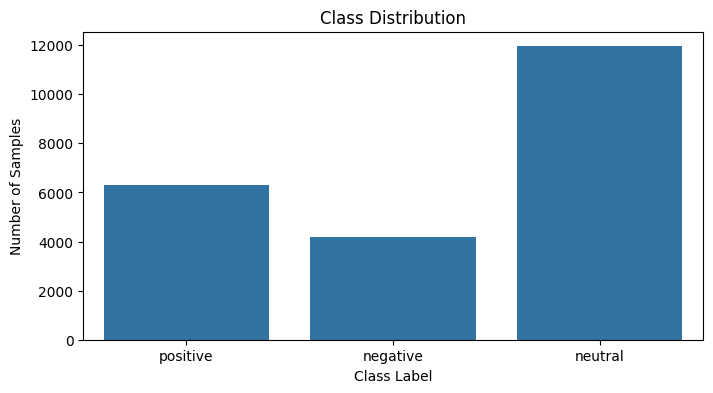

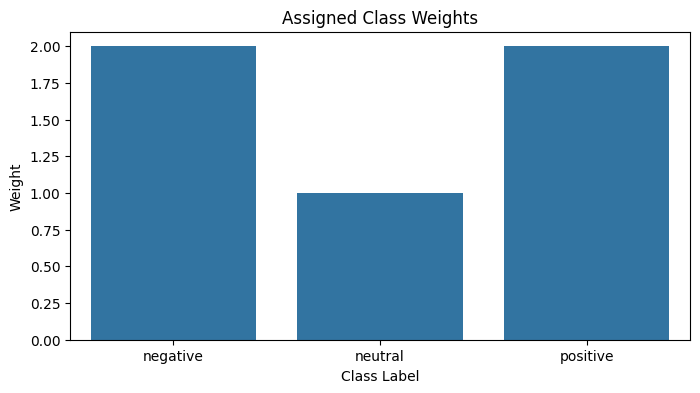

In [6]:
# Visualize class distribution and weights
import matplotlib.pyplot as plt
import seaborn as sns

# Class distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=labels)
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.show()

# Class weights visualization
plt.figure(figsize=(8, 4))
weight_items = sorted(class_weights.items(), key=lambda x: x[0])
weight_labels = [list(label_to_index.keys())[list(label_to_index.values()).index(idx)] for idx, _ in weight_items]
weight_values = [w for _, w in weight_items]
sns.barplot(x=weight_labels, y=weight_values)
plt.title('Assigned Class Weights')
plt.xlabel('Class Label')
plt.ylabel('Weight')
plt.show()

In [7]:
# Re-encode labels after balancing
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
y = np.array([label_to_index[label] for label in labels])
num_classes = len(label_to_index)
y_cat = to_categorical(y, num_classes=num_classes)

In [8]:
# 2. Tokenization and Embedding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)

In [9]:
# 3. K-Fold Cross-Validation
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

In [10]:
# 4. Model architectures
def build_cnn(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_rnn(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        SimpleRNN(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [11]:
# 5. Training and Evaluation
results = {'CNN': [], 'RNN': [], 'LSTM': []}
for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_cat[train_idx], y_cat[val_idx]
    y_val_labels = y[val_idx]
    vocab_size = min(10000, len(tokenizer.word_index) + 1)

    for name, build_fn in zip(['CNN', 'RNN', 'LSTM'], [build_cnn, build_rnn, build_lstm]):
        model = build_fn(maxlen, vocab_size, num_classes)
        model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        
        acc = accuracy_score(y_val_labels, y_pred)
        prec = precision_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        mcc = matthews_corrcoef(y_val_labels, y_pred)
        mse = mean_squared_error(y_val_labels, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val_labels, y_pred)
        
        results[name].append({
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'mcc': mcc,
            'mse': mse,
            'rmse': rmse,
            'r2': r2
        })
        print(f"Fold {fold+1} {name}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}, MSE={mse:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 1 CNN: Acc=0.6069, Prec=0.6086, Rec=0.6069, F1=0.6077, MCC=0.3509, MSE=0.5982, RMSE=0.7734, R2=-0.2994


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 1 RNN: Acc=0.5882, Prec=0.5810, Rec=0.5882, F1=0.5835, MCC=0.3078, MSE=0.6322, RMSE=0.7951, R2=-0.3732


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Fold 1 LSTM: Acc=0.6210, Prec=0.6106, Rec=0.6210, F1=0.6117, MCC=0.3498, MSE=0.5492, RMSE=0.7411, R2=-0.1930


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 2 CNN: Acc=0.6161, Prec=0.6103, Rec=0.6161, F1=0.6122, MCC=0.3517, MSE=0.5496, RMSE=0.7414, R2=-0.1994


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 2 RNN: Acc=0.5902, Prec=0.5802, Rec=0.5902, F1=0.5829, MCC=0.2996, MSE=0.5989, RMSE=0.7739, R2=-0.3068


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Fold 2 LSTM: Acc=0.6188, Prec=0.6113, Rec=0.6188, F1=0.6117, MCC=0.3534, MSE=0.5554, RMSE=0.7452, R2=-0.2119


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 3 CNN: Acc=0.6137, Prec=0.6049, Rec=0.6137, F1=0.6067, MCC=0.3400, MSE=0.5549, RMSE=0.7449, R2=-0.2172


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 3 RNN: Acc=0.5938, Prec=0.5858, Rec=0.5938, F1=0.5864, MCC=0.3107, MSE=0.6057, RMSE=0.7783, R2=-0.3288


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Fold 3 LSTM: Acc=0.6239, Prec=0.6163, Rec=0.6239, F1=0.6184, MCC=0.3603, MSE=0.5519, RMSE=0.7429, R2=-0.2108


In [12]:
# 6. Average metrics and select best model
import statistics
summary = {}
for name in results:
    avg_metrics = {metric: statistics.mean([fold[metric] for fold in results[name]]) for metric in results[name][0]}
    summary[name] = avg_metrics
    print(f"\n{name} Average Metrics:")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")


CNN Average Metrics:
accuracy: 0.6123
precision: 0.6079
recall: 0.6123
f1: 0.6088
mcc: 0.3476
mse: 0.5676
rmse: 0.7532
r2: -0.2387

RNN Average Metrics:
accuracy: 0.5907
precision: 0.5823
recall: 0.5907
f1: 0.5843
mcc: 0.3060
mse: 0.6123
rmse: 0.7824
r2: -0.3363

LSTM Average Metrics:
accuracy: 0.6212
precision: 0.6127
recall: 0.6212
f1: 0.6139
mcc: 0.3545
mse: 0.5522
rmse: 0.7431
r2: -0.2052


In [13]:
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'mcc', 'mse', 'rmse', 'r2']
plot_data = []
for name in results:
    for fold_idx, fold in enumerate(results[name]):
        fold_data = {'Model': name, 'Fold': f'Fold {fold_idx + 1}'}
        fold_data.update(fold)
        plot_data.append(fold_data)
plot_df = pd.DataFrame(plot_data)

In [14]:
for metric in metrics_to_plot:
    if metric in ['mse', 'rmse']:  # For these, lower is better
        best = min(summary, key=lambda x: summary[x][metric])
    else:  # For others, higher is better
        best = max(summary, key=lambda x: summary[x][metric])
    print(f"For {metric}, the winner is {best} (score: {summary[best][metric]:.4f})")
    

print(f"\nOverall Best Model: {best}")
print(f"This is because {best} achieved the best average scores across most metrics (accuracy, precision, recall, f1, mcc, mse, rmse, r2) \ncompared to the other two, indicating it generalizes better on this sentiment classification task.")


For accuracy, the winner is LSTM (score: 0.6212)
For precision, the winner is LSTM (score: 0.6127)
For recall, the winner is LSTM (score: 0.6212)
For f1, the winner is LSTM (score: 0.6139)
For mcc, the winner is LSTM (score: 0.3545)
For mse, the winner is LSTM (score: 0.5522)
For rmse, the winner is LSTM (score: 0.7431)
For r2, the winner is LSTM (score: -0.2052)

Overall Best Model: LSTM
This is because LSTM achieved the best average scores across most metrics (accuracy, precision, recall, f1, mcc, mse, rmse, r2) 
compared to the other two, indicating it generalizes better on this sentiment classification task.


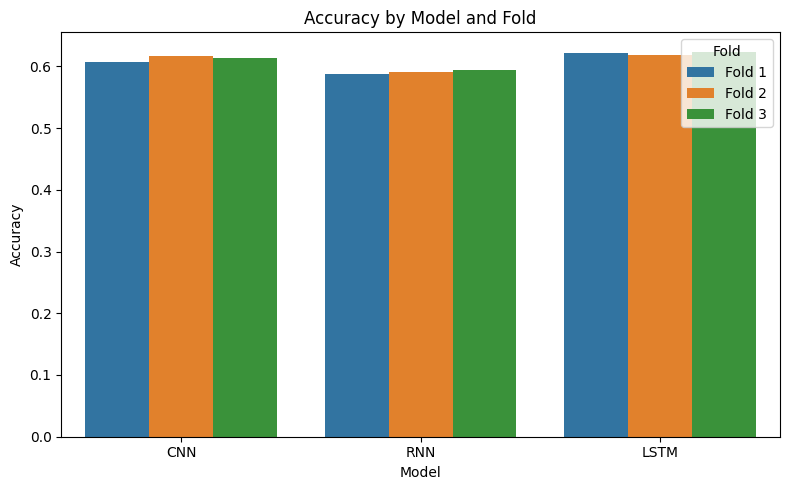

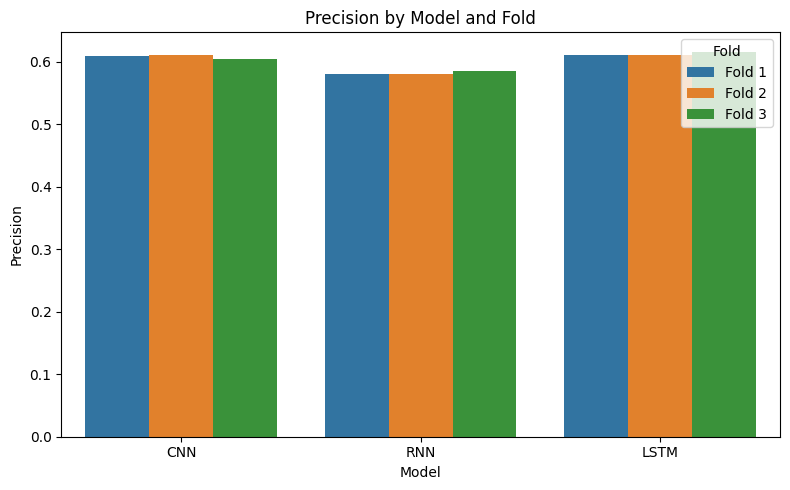

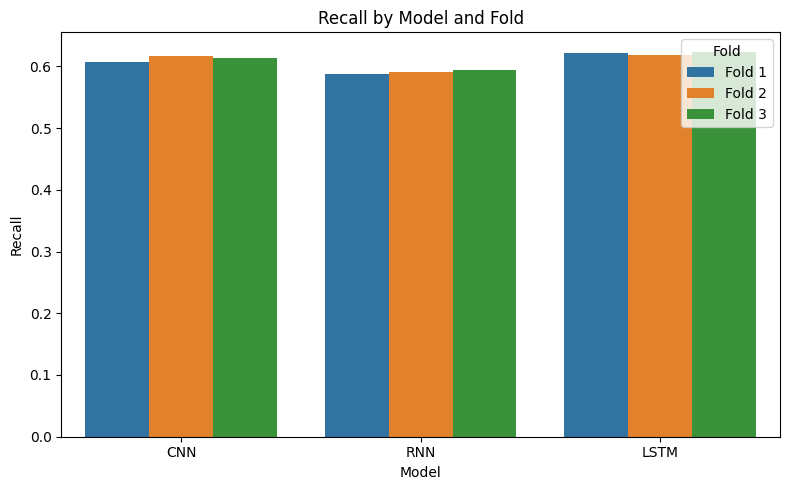

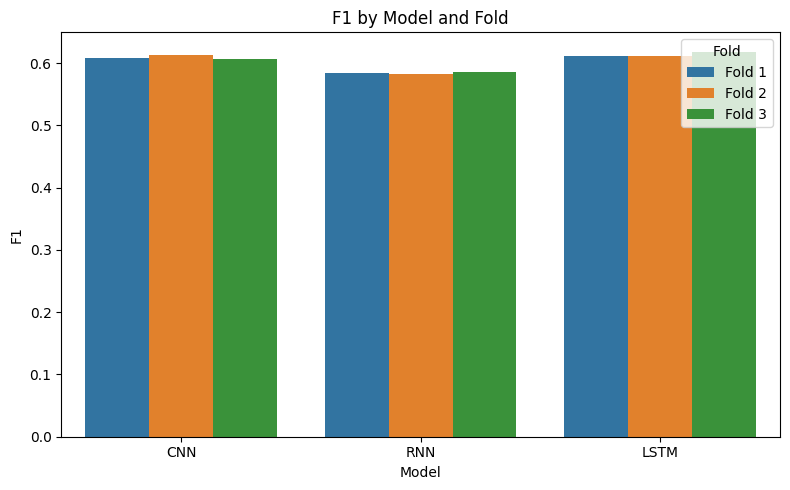

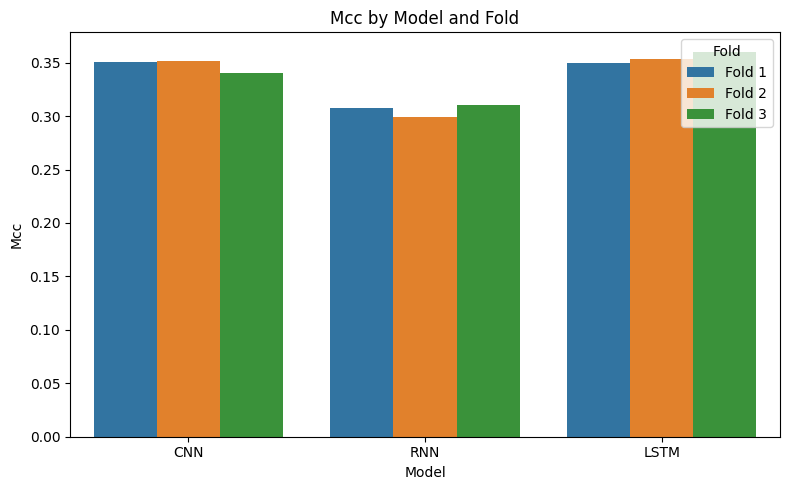

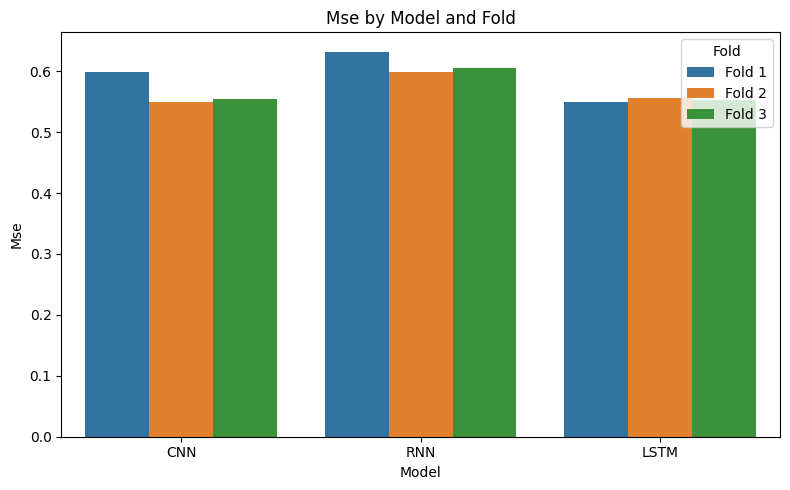

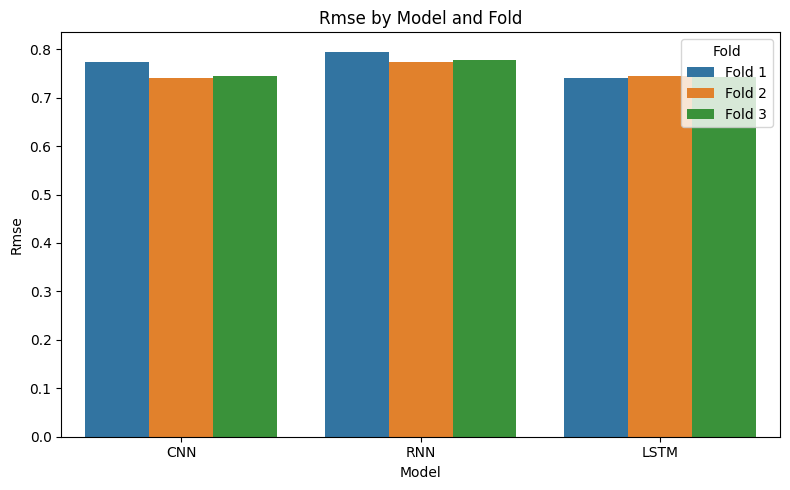

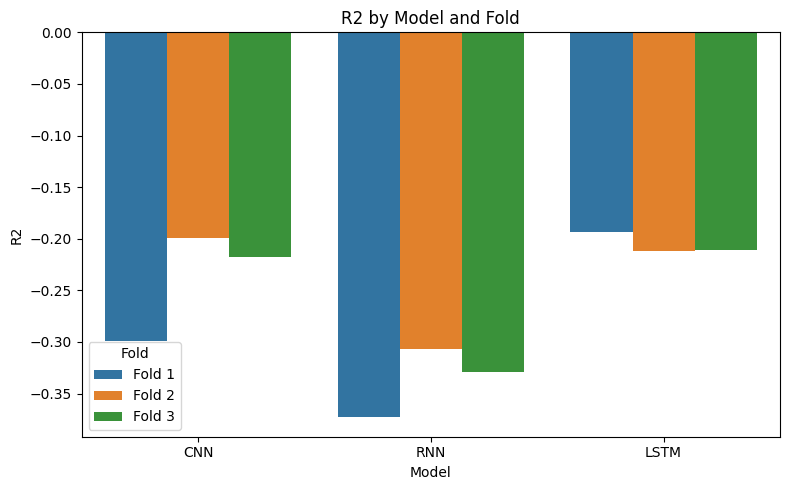

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    sns.barplot(data=plot_df, x='Model', y=metric, hue='Fold')
    plt.title(f'{metric.capitalize()} by Model and Fold')
    plt.ylabel(metric.capitalize())
    plt.tight_layout()
    plt.show()